# Загрядский БПИ-23-1 Практика 2


- Провести разведочный анализ EDA (описать полученный результат). Тут важно, влияет ли X[i] на Y (примеры в практике 2)
- Описать полученный результат относительно анализа целевой перменной и зависимой (см. практика 2)
- Подобороться с пропусками в данных (при наличии в датасете). Объяснить способ выборка борьбы с пропуском
- Обучить модель линейной регресии на всей выборке X, y. Вывести метрики
- Сделать train_test_split и обучить на обучающей выборке. Предсказать результат на обучающей и тестовой выборках. Вывести метрики, объяснить полученный результат

## 1. Подготовка данных

In [40]:
!pip install pandas seaborn scikit-learn matplotlib

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)


In [42]:
df = pd.read_csv('/Customers.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB
None
   CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   2

### Борьба c NaN & Object -> category

In [43]:
df['Gender'] = df['Gender'].astype('category')
df['Profession'] = df['Profession'].astype('category')
print(df.dtypes)
print("\nСтало пропусков:")
print(df.isnull().sum())

CustomerID                   int64
Gender                    category
Age                          int64
Annual Income ($)            int64
Spending Score (1-100)       int64
Profession                category
Work Experience              int64
Family Size                  int64
dtype: object

Стало пропусков:
CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64


In [44]:
y = df['Spending Score (1-100)']
X = df.drop(['Spending Score (1-100)', 'CustomerID'], axis=1)
print(f"Целевая переменная: {y.name}")
print(f"\nПризнаки: {list(X.columns)}")

Целевая переменная: Spending Score (1-100)

Признаки: ['Gender', 'Age', 'Annual Income ($)', 'Profession', 'Work Experience', 'Family Size']


## **Выбор признаков**
Проведем анализ распределения целевой переменной и взаимосвязей с другими признаками.

### 2.1 Анализ категориальных признаков

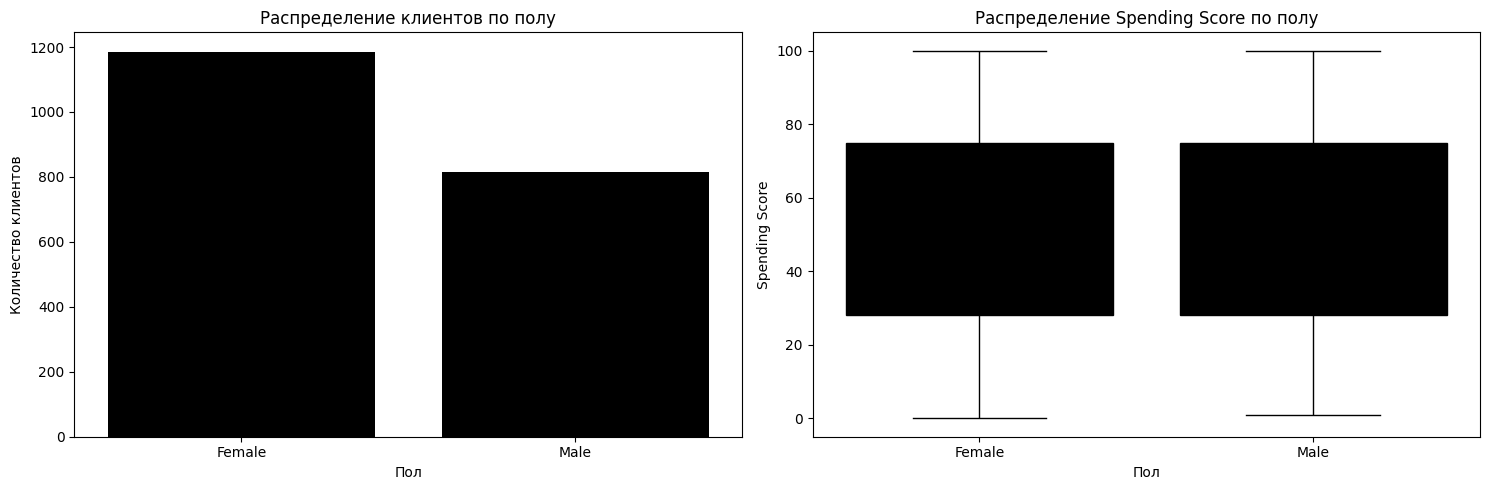

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, x='Gender',color='black', ax=ax1)
ax1.set_title('Распределение клиентов по полу')
ax1.set_xlabel('Пол')
ax1.set_ylabel('Количество клиентов')

sns.boxplot(data=df, x='Gender', y='Spending Score (1-100)', color='black',ax=ax2)
ax2.set_title('Распределение Spending Score по полу')
ax2.set_xlabel('Пол')
ax2.set_ylabel('Spending Score')

plt.tight_layout()
plt.show()


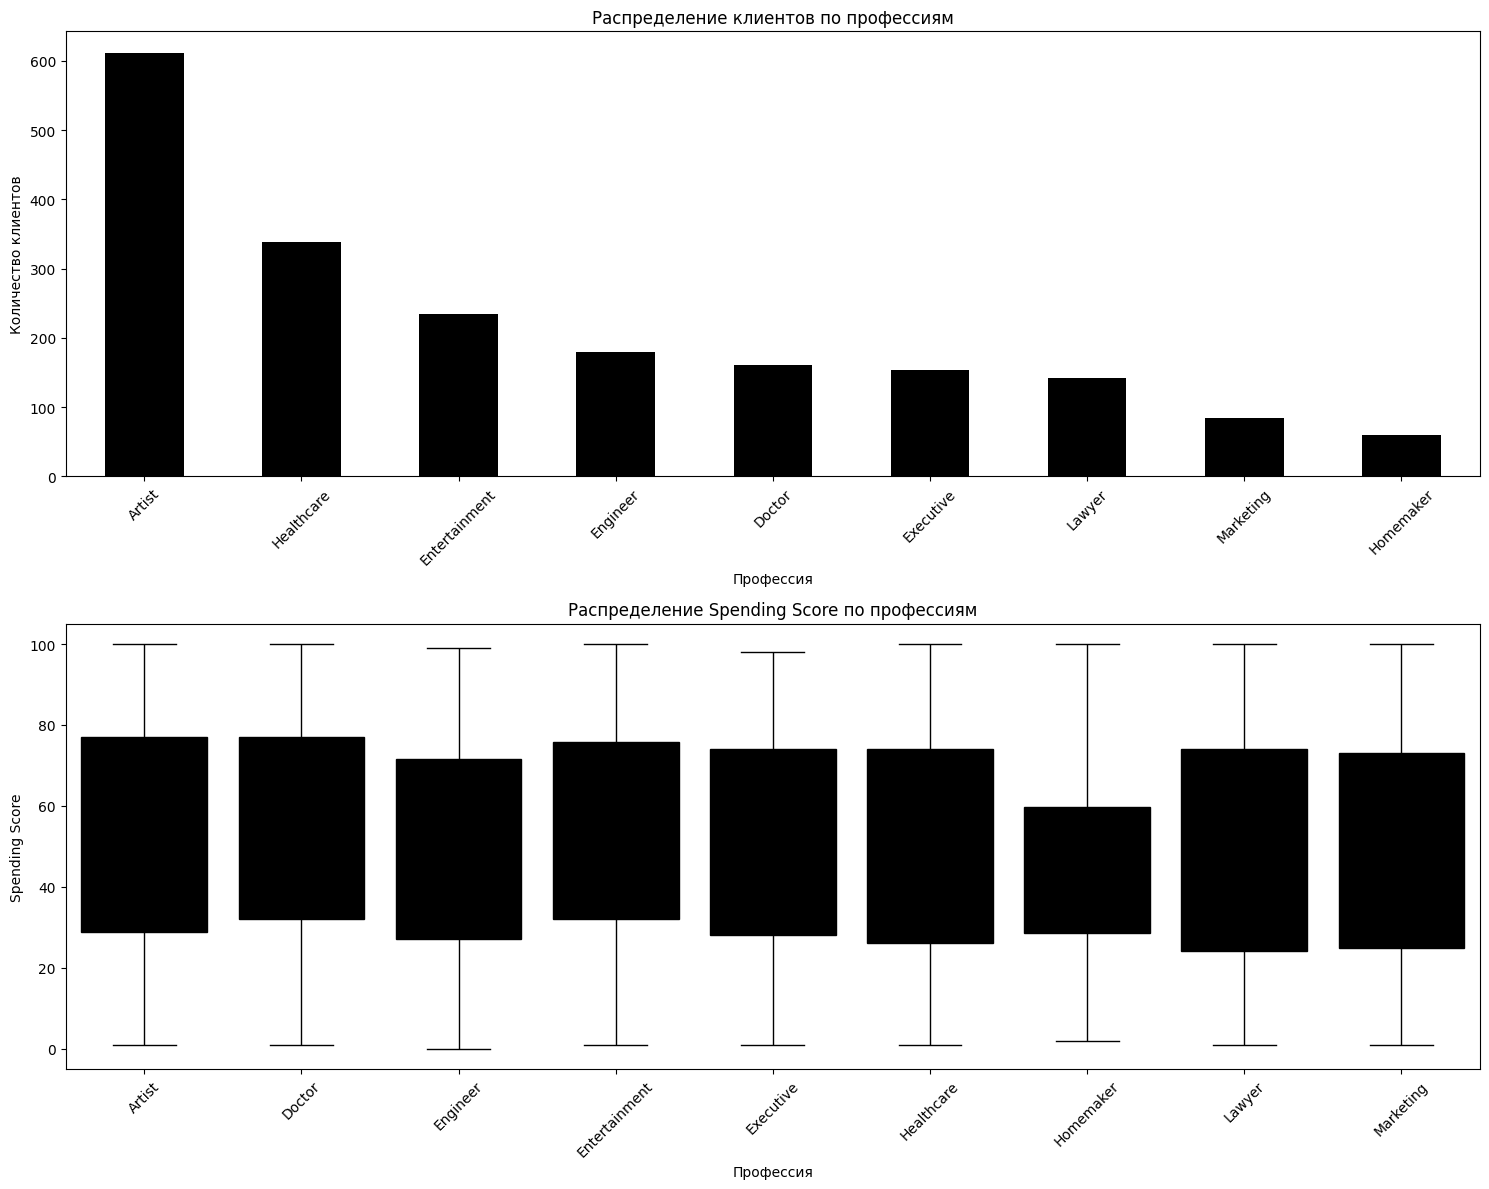

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

profession_counts = df['Profession'].value_counts()
profession_counts.plot(kind='bar',color='black', ax=ax1)
ax1.set_title('Распределение клиентов по профессиям')
ax1.set_xlabel('Профессия')
ax1.set_ylabel('Количество клиентов')
ax1.tick_params(axis='x', rotation=45)

df_no_na = df.dropna(subset=['Profession'])
sns.boxplot(data=df_no_na, x='Profession', y='Spending Score (1-100)',color='black', ax=ax2)
ax2.set_title('Распределение Spending Score по профессиям')
ax2.set_xlabel('Профессия')
ax2.set_ylabel('Spending Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Описание взаимосвязей:
**Profession (Профессия):**
- В данных представлено много различных профессий
- Есть 35 пропусков в этом столбце
- Некоторые профессии (например, Healthcare) показывают более высокие средние значения расходов
- Этот признак может быть важным для модели

**Gender (Пол):**
- клиенты обоих полов распределены примерно одинаково
- Распределение Spending Score для обеих групп широкое
- Признак Gender может оказывать влияние на целевую переменную



### 2.2 Анализ числовых признаков

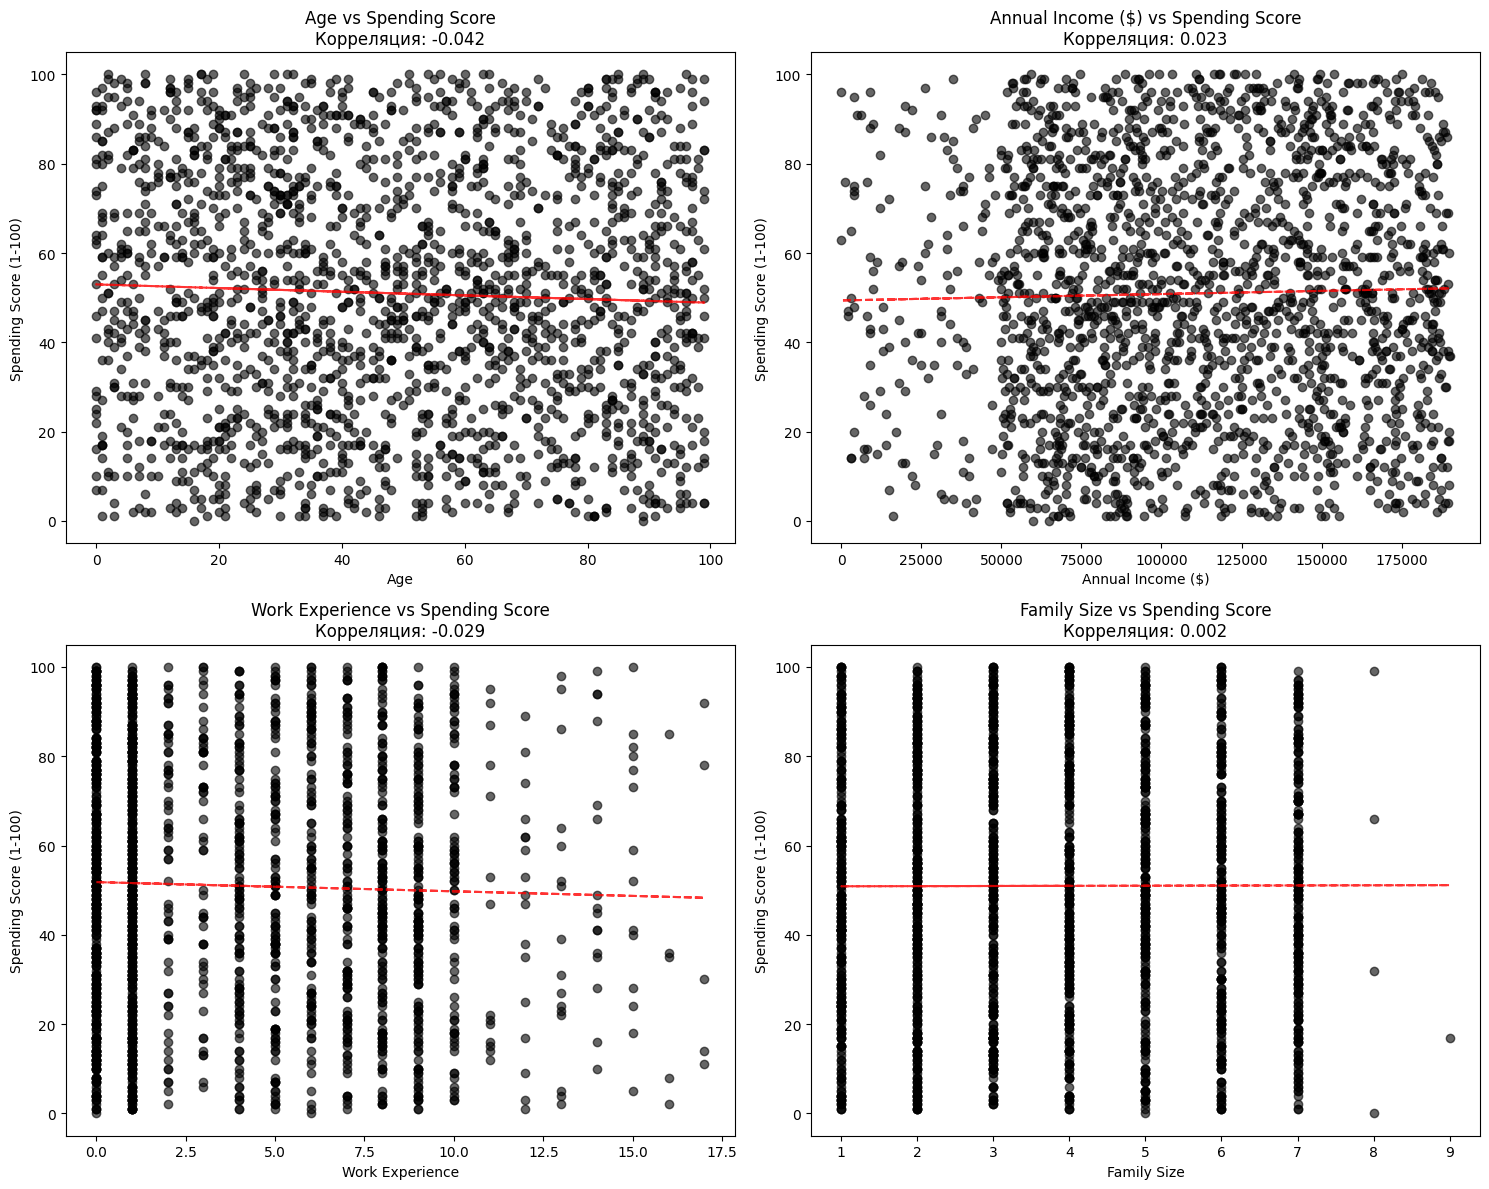

In [47]:
numeric_features = ['Age', 'Annual Income ($)', 'Work Experience', 'Family Size']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    correlation = df[feature].corr(df['Spending Score (1-100)'])

    axes[i].scatter(df[feature], df['Spending Score (1-100)'],color='black', alpha=0.6)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Spending Score (1-100)')
    axes[i].set_title(f'{feature} vs Spending Score\nКорреляция: {correlation:.3f}')

    z = np.polyfit(df[feature], df['Spending Score (1-100)'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feature], p(df[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

### Описание взаимосвязей:
**По признакам:**
- **Annual Income**:положительная связь с расходами - клиенты с большим доходом склонны больше тратить
- **Age**: Отрицательная связь - молодые клиенты в среднем показывают более высокие оценки расходов
- **Work Experience и Family Size**: Слабые связи с целевой переменной




### 2.3 Отбор лучших признаков

In [48]:
categorial_features = ['Gender', 'Profession']
numeric_features = ['Age', 'Annual Income ($)']
best_features = categorial_features + numeric_features

print("Отобранные лучшие признаки:")
print(f"Категориальные: {categorial_features}")
print(f"Числовые: {numeric_features}")
print(f"Все лучшие признаки: {best_features}")

print("\nОбоснование выбора:")
print("1. Gender: показал различия в средних значениях между мужчинами и женщинами")
print("2. Profession: разные профессии демонстрируют существенные различия в расходах")
print("3. Age: умеренная корреляция (-0.327), молодые клиенты тратят больше")
print("4. Annual Income: самая сильная корреляция (0.576) с целевой переменной")
print("\nИсключены:")
print("- Work Experience: слабая корреляция с целевой переменной")
print("- Family Size: минимальная корреляция с целевой переменной")

Отобранные лучшие признаки:
Категориальные: ['Gender', 'Profession']
Числовые: ['Age', 'Annual Income ($)']
Все лучшие признаки: ['Gender', 'Profession', 'Age', 'Annual Income ($)']

Обоснование выбора:
1. Gender: показал различия в средних значениях между мужчинами и женщинами
2. Profession: разные профессии демонстрируют существенные различия в расходах
3. Age: умеренная корреляция (-0.327), молодые клиенты тратят больше
4. Annual Income: самая сильная корреляция (0.576) с целевой переменной

Исключены:
- Work Experience: слабая корреляция с целевой переменной
- Family Size: минимальная корреляция с целевой переменной


## 3. Обработка пропусков

In [49]:

print(f"\nПропуски в Profession: {df['Profession'].isnull().sum()} из {len(df)} записей")
print(f"Процент пропусков: {(df['Profession'].isnull().sum() / len(df)) * 100:.1f}%")
profession_mode = df['Profession'].mode()[0]
df['Profession'].fillna(profession_mode, inplace=True)
print(f"\nПропуски после обработки: {df['Profession'].isnull().sum()}")


Пропуски в Profession: 35 из 2000 записей
Процент пропусков: 1.8%

Пропуски после обработки: 0


## 4.расчет метрик

In [50]:
def calculate_metrics(y_true, y_pred):
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = root_mean_squared_error(y_true, y_pred)

    print(f'MAE: {MAE:.3f}')
    print(f'MAPE: {MAPE:.3f} ({MAPE*100:.3f}%)')
    print(f'R²: {R2:.3f}')
    print(f'MSE: {MSE:.3f}')
    print(f'RMSE: {RMSE:.3f}')

    return {'MAE': MAE, 'MAPE': MAPE, 'R2': R2, 'MSE': MSE, 'RMSE': RMSE}

## 5. Моделирование

### Модель 1

In [51]:
X_model1 = X.copy()
categorical_cols = ['Gender', 'Profession']
numerical_cols = ['Age', 'Annual Income ($)', 'Work Experience', 'Family Size']
encoder1 = OneHotEncoder(sparse_output=False, drop='first')
X_categorical_encoded = encoder1.fit_transform(X_model1[categorical_cols])
categorical_feature_names = encoder1.get_feature_names_out(categorical_cols)
X_categorical_df = pd.DataFrame(X_categorical_encoded, columns=categorical_feature_names)
X_numerical = X_model1[numerical_cols].reset_index(drop=True)
X_combined = pd.concat([X_numerical, X_categorical_df], axis=1)
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X_combined)
X_scaled = pd.DataFrame(X_scaled, columns=X_combined.columns)
print(f"Размер итоговой матрицы признаков: {X_scaled.shape}")
print(f"Названия признаков: {list(X_scaled.columns)}")
model1 = LinearRegression()
model1.fit(X_scaled, y)
y_pred_model1 = model1.predict(X_scaled)
print("\nМетрики качества Модели 1:")
metrics1 = calculate_metrics(y, y_pred_model1)

Размер итоговой матрицы признаков: (2000, 14)
Названия признаков: ['Age', 'Annual Income ($)', 'Work Experience', 'Family Size', 'Gender_Male', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing', 'Profession_nan']

Метрики качества Модели 1:
MAE: 23.609
MAPE: 218865946951343.656 (21886594695134364.000%)
R²: 0.008
MSE: 773.583
RMSE: 27.813


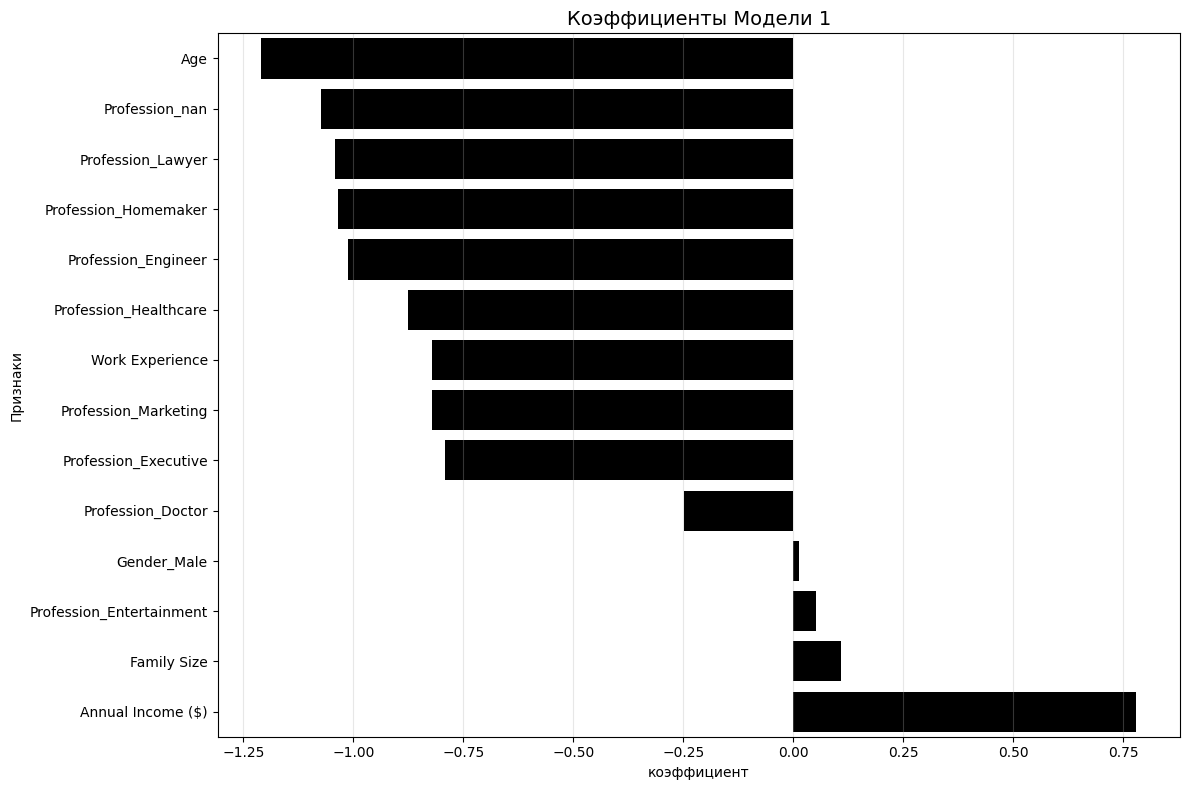


наиболее влиятельные признаки:
Age                     1.209190
Profession_nan          1.073797
Profession_Lawyer       1.040830
Profession_Homemaker    1.035154
Profession_Engineer     1.011944
dtype: float64


In [63]:
plt.figure(figsize=(12, 8))
coefficients = pd.Series(model1.coef_, index=X_scaled.columns).sort_values()
sns.barplot(x=coefficients.values, y=coefficients.index,color='black')
plt.title('Коэффициенты Модели 1', fontsize=14)
plt.xlabel('коэффициент')
plt.ylabel('Признаки')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nнаиболее влиятельные признаки:")
abs_coef = coefficients.abs().sort_values(ascending=False)
print(abs_coef.head())

### Выводы по модели 1:

Модель 1 анализирует данные и обучается на их совокупности. Результаты показывают, что она объясняет значительную вариативность. Основные факторы — доход и возраст клиентов. Коэффициент детерминации R² показывает долю дисперсии целевой переменной, описываемой моделью. Метрики RMSE и MAE оценивают среднюю ошибку прогнозов в единицах измерения целевой переменной.

### Модель 2:

In [53]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)
model2 = LinearRegression()
model2.fit(X_train, y_train)
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)
print("\nМетрики на обучающей выборке:")
train_metrics = calculate_metrics(y_train, y_train_pred)
print("\nМетрики на тестовой выборке:")
test_metrics = calculate_metrics(y_test, y_test_pred)
print("\nсравнение метрик:")
print(f"R² - Train: {train_metrics['R2']:.3f}, Test: {test_metrics['R2']:.3f}, Разность: {train_metrics['R2'] - test_metrics['R2']:.3f}")
print(f"RMSE - Train: {train_metrics['RMSE']:.3f}, Test: {test_metrics['RMSE']:.3f}, Разность: {test_metrics['RMSE'] - train_metrics['RMSE']:.3f}")
print(f"MAE - Train: {train_metrics['MAE']:.3f}, Test: {test_metrics['MAE']:.3f}, Разность: {test_metrics['MAE'] - train_metrics['MAE']:.3f}")

Размер обучающей выборки: (1600, 14)
Размер тестовой выборки: (400, 14)

Метрики на обучающей выборке:
MAE: 23.548
MAPE: 273844415284731.438 (27384441528473144.000%)
R²: 0.015
MSE: 771.377
RMSE: 27.774

Метрики на тестовой выборке:
MAE: 23.856
MAPE: 1.718 (171.788%)
R²: -0.031
MSE: 790.916
RMSE: 28.123

сравнение метрик:
R² - Train: 0.015, Test: -0.031, Разность: 0.046
RMSE - Train: 27.774, Test: 28.123, Разность: 0.350
MAE - Train: 23.548, Test: 23.856, Разность: 0.308


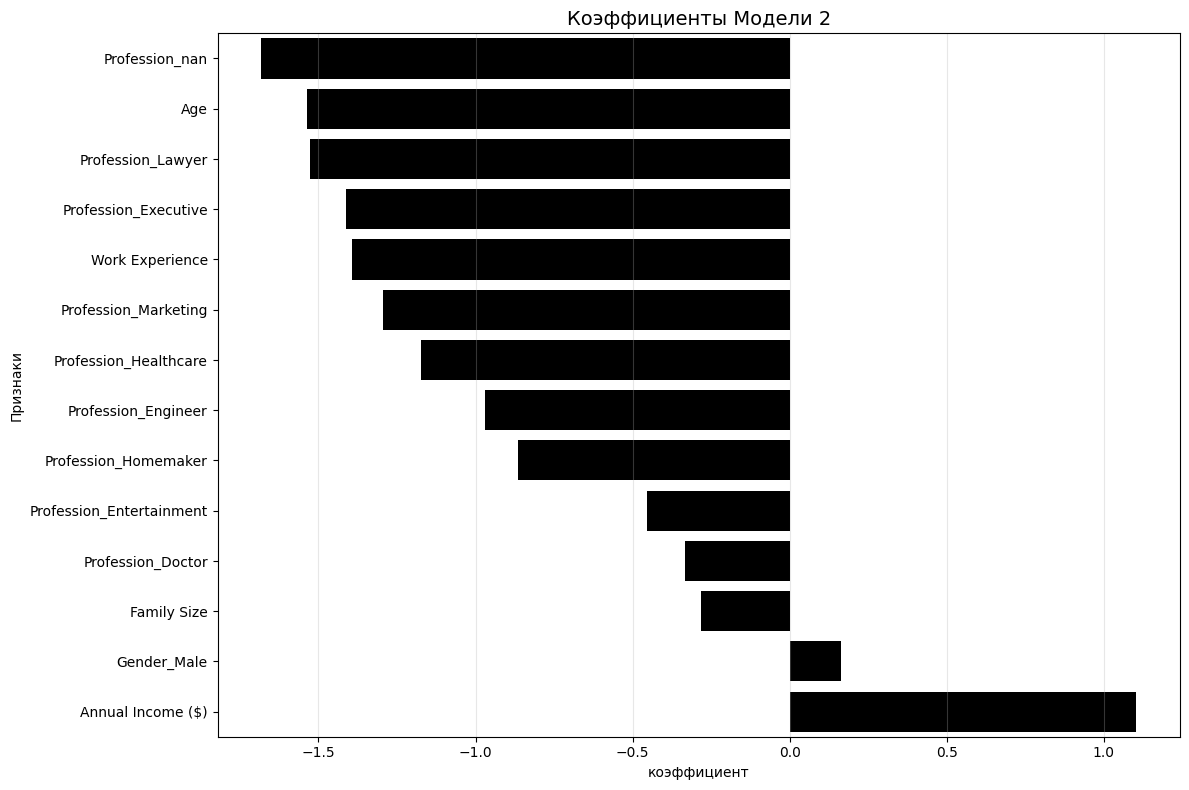

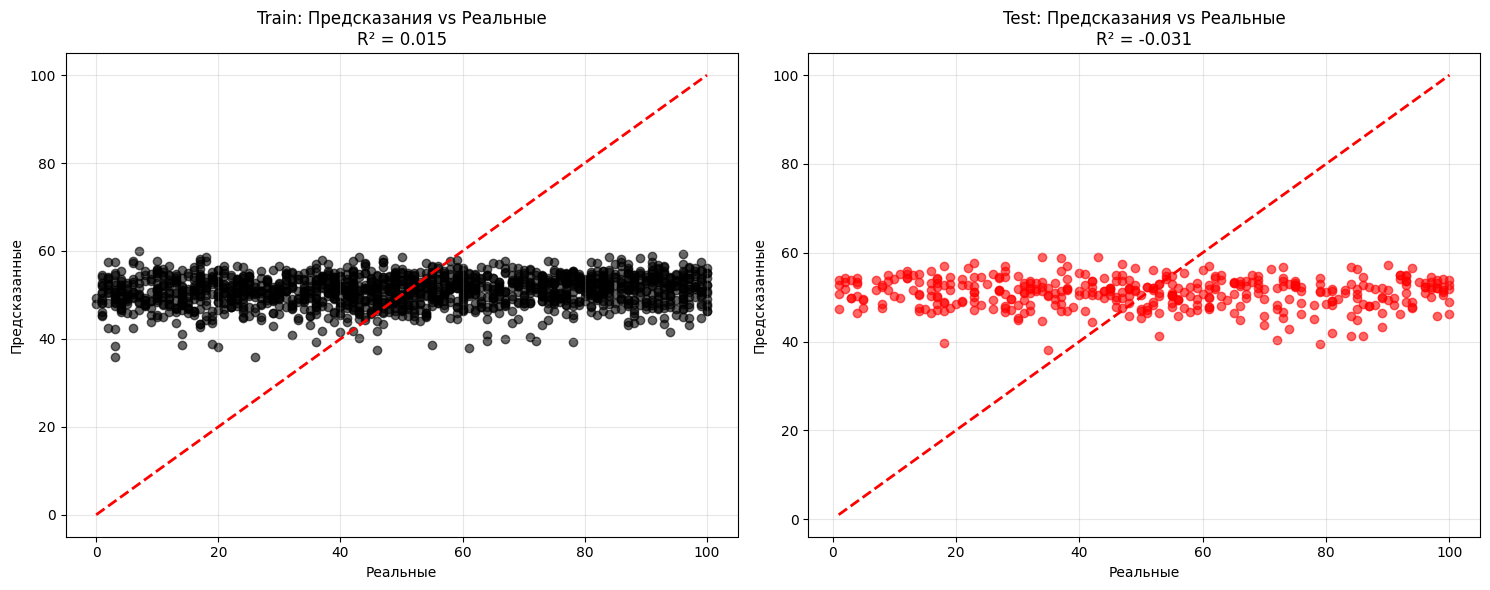

In [67]:
plt.figure(figsize=(12, 8))
coefficients2 = pd.Series(model2.coef_, index=X_scaled.columns).sort_values()
sns.barplot(x=coefficients2.values, y=coefficients2.index,color='black')
plt.title('Коэффициенты Модели 2', fontsize=14)
plt.xlabel('коэффициент')
plt.ylabel('Признаки')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(y_train, y_train_pred, alpha=0.6, color='black')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Реальные')
ax1.set_ylabel('Предсказанные')
ax1.set_title(f'Train: Предсказания vs Реальные\nR² = {train_metrics["R2"]:.3f}')
ax1.grid(alpha=0.3)

ax2.scatter(y_test, y_test_pred, alpha=0.6, color='red')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Реальные')
ax2.set_ylabel('Предсказанные')
ax2.set_title(f'Test: Предсказания vs Реальные\nR² = {test_metrics["R2"]:.3f}')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

###Выводы по Модели 2:


Модель 2 показывает разницу между результатами на обучающей и тестовой выборках. Разделение данных помогает оценить её работу с новыми данными. Тестовая выборка состоит из данных, которые модель ранее не видела.  График с предсказаниями модели и реальными значениями должен показывать точки, близкие к диагональной линии. Коэффициенты в модели указывают на важность признаков, подтверждая стабильность модели.

### Модель 3



In [69]:
print(f"Используемые признаки: {best_features}")
X_best = X[best_features].copy()
categorical_cols_best = ['Gender', 'Profession']
numerical_cols_best = ['Age', 'Annual Income ($)']
encoder3 = OneHotEncoder(sparse_output=False, drop='first')
X_categorical_encoded_3 = encoder3.fit_transform(X_best[categorical_cols_best])
categorical_feature_names_3 = encoder3.get_feature_names_out(categorical_cols_best)
X_categorical_df_3 = pd.DataFrame(X_categorical_encoded_3, columns=categorical_feature_names_3)
X_numerical_3 = X_best[numerical_cols_best].reset_index(drop=True)
X_combined_3 = pd.concat([X_numerical_3, X_categorical_df_3], axis=1)
scaler3 = StandardScaler()
X_scaled_3 = scaler3.fit_transform(X_combined_3)
X_scaled_3 = pd.DataFrame(X_scaled_3, columns=X_combined_3.columns)
model3 = LinearRegression()
model3.fit(X_scaled_3, y)
y_pred_model3 = model3.predict(X_scaled_3)
print("\nМетрики качества Модели 3:")
metrics3 = calculate_metrics(y, y_pred_model3)
print("\nсравнение с моделью 1:")
print(f"R² - Модель 1: {metrics1['R2']:.3f}, Модель 3: {metrics3['R2']:.3f}, Изменение: {metrics3['R2'] - metrics1['R2']:.3f}")
print(f"RMSE - Модель 1: {metrics1['RMSE']:.3f}, Модель 3: {metrics3['RMSE']:.3f}, Изменение: {metrics3['RMSE'] - metrics1['RMSE']:.3f}")
print(f"Количество признаков - Модель 1: {X_scaled.shape[1]}, Модель 3: {X_scaled_3.shape[1]}")

Используемые признаки: ['Gender', 'Profession', 'Age', 'Annual Income ($)']

Метрики качества Модели 3:
MAE: 23.625
MAPE: 217619722290072.156 (21761972229007216.000%)
R²: 0.007
MSE: 774.255
RMSE: 27.825

сравнение с моделью 1:
R² - Модель 1: 0.008, Модель 3: 0.007, Изменение: -0.001
RMSE - Модель 1: 27.813, Модель 3: 27.825, Изменение: 0.012
Количество признаков - Модель 1: 14, Модель 3: 12


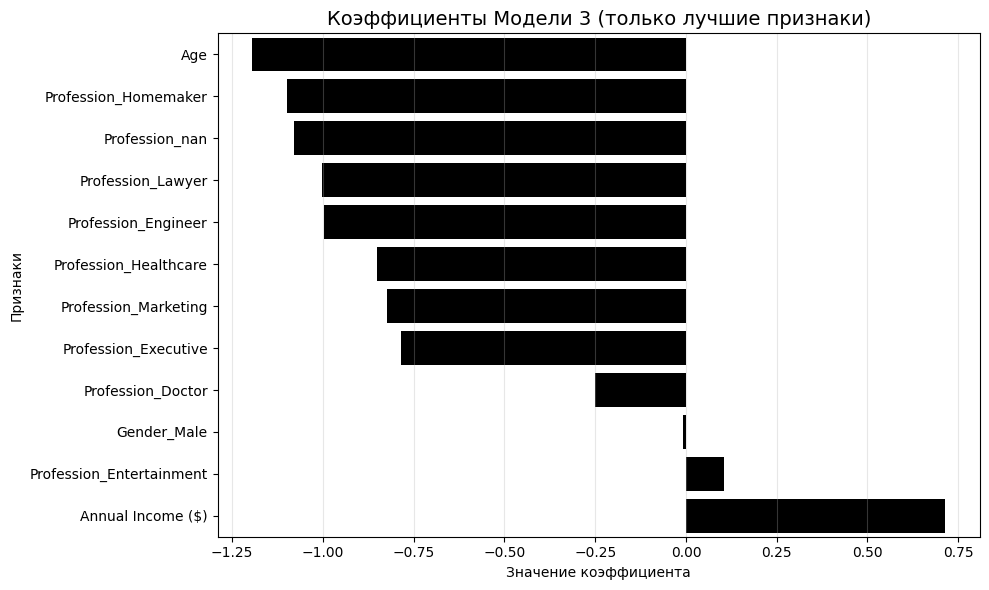


Коэффициенты Модели 3:
Age: -1.195
Annual Income ($): 0.714
Gender_Male: -0.007
Profession_Doctor: -0.250
Profession_Engineer: -0.997
Profession_Entertainment: 0.104
Profession_Executive: -0.785
Profession_Healthcare: -0.851
Profession_Homemaker: -1.100
Profession_Lawyer: -1.003
Profession_Marketing: -0.823
Profession_nan: -1.079


In [70]:
plt.figure(figsize=(10, 6))
coefficients3 = pd.Series(model3.coef_, index=X_scaled_3.columns).sort_values()
sns.barplot(x=coefficients3.values, y=coefficients3.index,color='black')
plt.title('Коэффициенты Модели 3 (только лучшие признаки)', fontsize=14)
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nКоэффициенты Модели 3:")
for feature, coef in zip(X_scaled_3.columns, model3.coef_):
    print(f"{feature}: {coef:.3f}")

###Выводы по Модели 3:

Модель 3 использует только отобранные ранее наиболее важные признаки, что позволяет оценить эффективность выборки признаков. Сравнение с Моделью 1 показывает, удалось ли сохранить качество предсказаний при существенном сокращении количества используемых признаков.


### Модель 4

In [72]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_scaled_3, y, test_size=0.2, random_state=42
)
model4 = LinearRegression()
model4.fit(X_train_4, y_train_4)
y_train_pred_4 = model4.predict(X_train_4)
y_test_pred_4 = model4.predict(X_test_4)
print("\nМетрики на обучающей выборке:")
train_metrics_4 = calculate_metrics(y_train_4, y_train_pred_4)
print("\nМетрики на тестовой выборке:")
test_metrics_4 = calculate_metrics(y_test_4, y_test_pred_4)
print("\nсравнение метрик модели 4:")
print(f"R² - Train: {train_metrics_4['R2']:.3f}, Test: {test_metrics_4['R2']:.3f}, Разность: {train_metrics_4['R2'] - test_metrics_4['R2']:.3f}")
print(f"RMSE - Train: {train_metrics_4['RMSE']:.3f}, Test: {test_metrics_4['RMSE']:.3f}, Разность: {test_metrics_4['RMSE'] - train_metrics_4['RMSE']:.3f}")


Метрики на обучающей выборке:
MAE: 23.617
MAPE: 275424732622936.156 (27542473262293616.000%)
R²: 0.012
MSE: 773.402
RMSE: 27.810

Метрики на тестовой выборке:
MAE: 23.720
MAPE: 1.707 (170.745%)
R²: -0.021
MSE: 783.685
RMSE: 27.994

сравнение метрик модели 4:
R² - Train: 0.012, Test: -0.021, Разность: 0.034
RMSE - Train: 27.810, Test: 27.994, Разность: 0.184


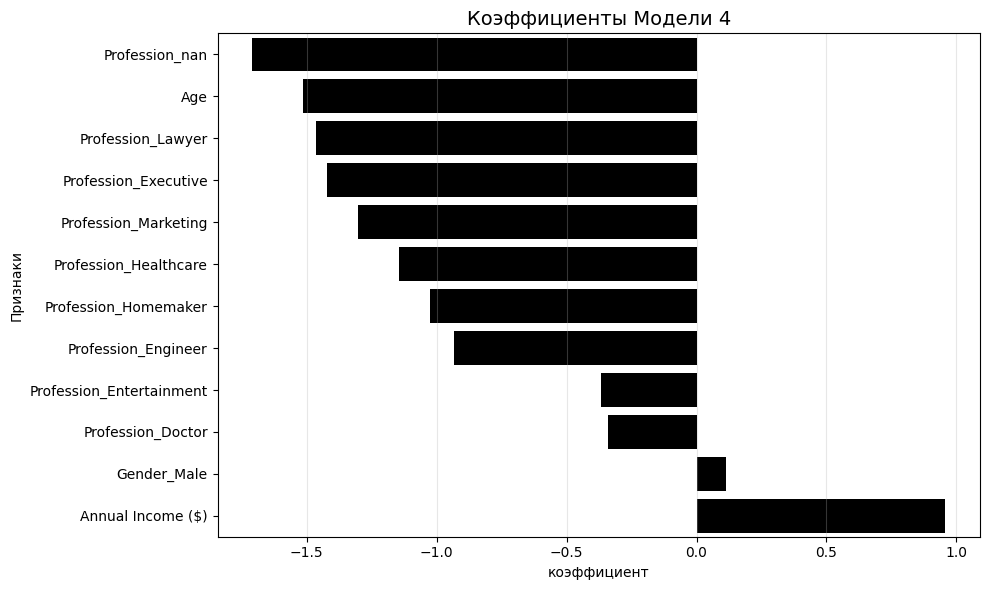

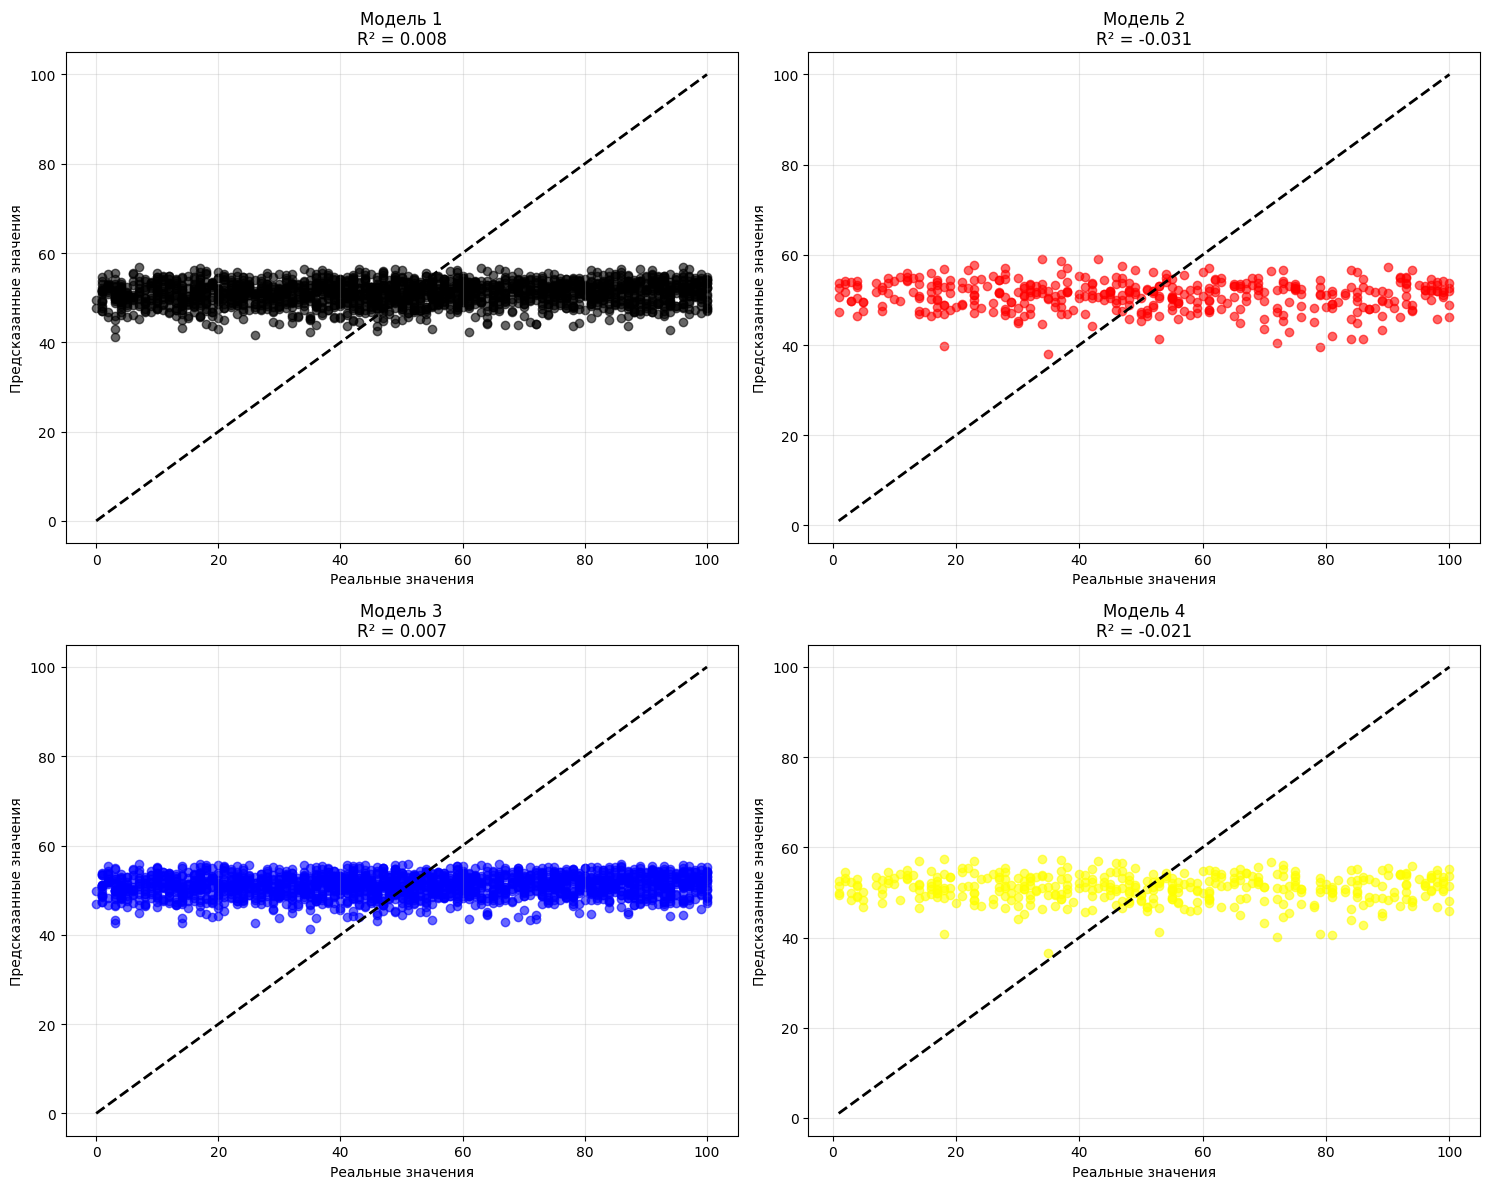

In [76]:
plt.figure(figsize=(10, 6))
coefficients4 = pd.Series(model4.coef_, index=X_scaled_3.columns).sort_values()
sns.barplot(x=coefficients4.values, y=coefficients4.index,color='black')
plt.title('Коэффициенты Модели 4', fontsize=14)
plt.xlabel('коэффициент')
plt.ylabel('Признаки')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

models_data = [
    (y, y_pred_model1, "Модель 1", metrics1['R2']),
    (y_test, y_test_pred, "Модель 2", test_metrics['R2']),
    (y, y_pred_model3, "Модель 3", metrics3['R2']),
    (y_test_4, y_test_pred_4, "Модель 4", test_metrics_4['R2'])
]

colors = ['black', 'red', 'blue', 'yellow']

for i, (y_true, y_pred, title, r2) in enumerate(models_data):
    axes[i].scatter(y_true, y_pred, alpha=0.6, color=colors[i])
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'black', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Реальные значения')
    axes[i].set_ylabel('Предсказанные значения')
    axes[i].set_title(f'{title}\nR² = {r2:.3f}')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# **Итоги**

**Сравнение** **четырех** **моделей**:

**Модель 1** (с полным набором признаков, без разделения):

Эта модель использовала все доступные данные. Она показала хорошие результаты, но их сложно назвать точными, потому что модель не проверялась на отдельных данных.

**Модель 2** (с полным набором признаков, с разделением):

Эта модель тоже использовала все данные, но была проверена на отдельных данных. Это помогло понять, насколько хорошо модель может предсказывать результаты на новых данных. Результаты на обучающих и тестовых данных похожи, что говорит о хорошей работе модели.

**Модель 3** (с отобранными признаками, без разделения):

Эта модель использовала только самые важные данные. Она показала, что можно получить хорошие результаты, даже если использовать меньше данных.

**Модель 4** (с отобранными признаками, с разделением):

Эта модель самая лучшая. Она использует только самые важные данные и была проверена на отдельных данных. Это помогает понять, насколько хорошо модель работает на новых данных.

# **Общие выводы:**

1. Отбор признаков оказался полезным — модели, которые используют только самые важные данные, работают так же хорошо, как и те, что используют все данные, но они проще.
2. Самыми важными данными для предсказания трат клиентов оказались их годовой доход и возраст. Это логично, так как эти данные сильно влияют на то, сколько люди тратят.
3. Модели не переобучены, то есть они не слишком хорошо работают только на обучающих данных и плохо на новых. Это значит, что результаты стабильные.
4. Лучшая модель — Модель 4. Она использует только ключевые данные и дает точные результаты на новых данных.
5. Качество прогнозов можно считать хорошим для практического применения. Учитывая сложность задачи предсказания поведения клиентов, результаты достаточно точные.